## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID, dest=Path().home()/'programming/data')
path.ls()

[PosixPath('/home/neronicolo/programming/data/camvid/images'),
 PosixPath('/home/neronicolo/programming/data/camvid/valid.txt'),
 PosixPath('/home/neronicolo/programming/data/camvid/codes.txt'),
 PosixPath('/home/neronicolo/programming/data/camvid/labels')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [ ]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [12]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/neronicolo/programming/data/camvid/images/0016E5_05010.png'),
 PosixPath('/home/neronicolo/programming/data/camvid/images/0006R0_f03600.png'),
 PosixPath('/home/neronicolo/programming/data/camvid/images/0016E5_05460.png')]

In [13]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/neronicolo/programming/data/camvid/labels/Seq05VD_f04650_P.png'),
 PosixPath('/home/neronicolo/programming/data/camvid/labels/0016E5_07989_P.png'),
 PosixPath('/home/neronicolo/programming/data/camvid/labels/0001TP_010320_P.png')]

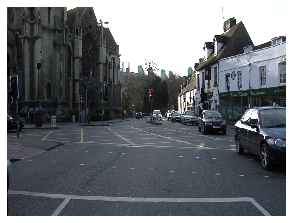

In [14]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [15]:
f'{fnames[0]}'

'/home/neronicolo/programming/data/camvid/images/0016E5_05010.png'

In [16]:
f'{fnames[0].stem}'

'0016E5_05010'

In [17]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
get_y_fn(fnames[0])

PosixPath('/home/neronicolo/programming/data/camvid/labels/0016E5_05010_P.png')

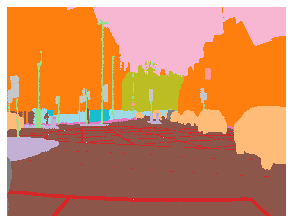

In [18]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [19]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]),
 tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17]]]))

In [20]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [21]:
l = [26, 21, 18]

In [22]:
codes[l]

array(['Tree', 'Sky', 'RoadShoulder'], dtype='<U17')

## Datasets

In [23]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 3415MB of GPU RAM free


In [24]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [34]:
valid_txt = open(path/'valid.txt', 'r')
l = valid_txt.read().split()

l[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

In [35]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

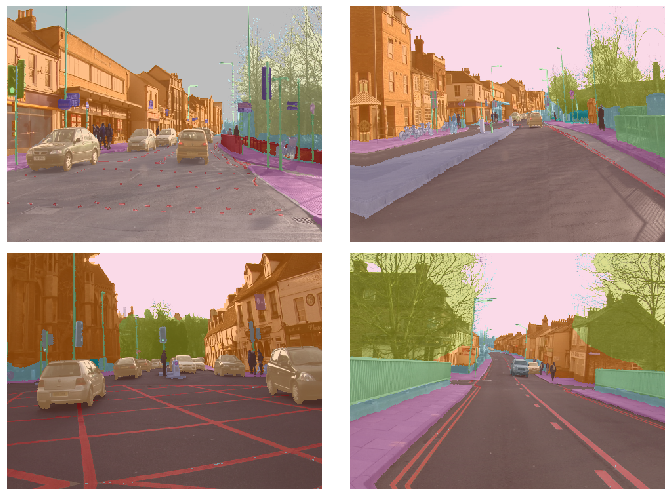

In [36]:
data.show_batch(2, figsize=(10,7))

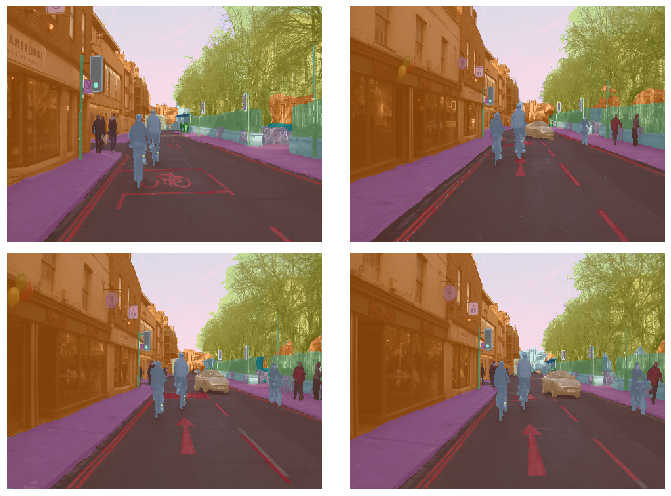

In [37]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [41]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [44]:
{v:k for k,v in enumerate(codes)}

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [46]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [47]:
metrics=acc_camvid
# metrics=accuracy

In [49]:
wd=1e-2

In [50]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/neronicolo/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 18.5MB/s]


In [52]:
lr_find(learn)
learn.recorder.plot()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.94 GiB total capacity; 2.88 GiB already allocated; 17.12 MiB free; 2.92 GiB reserved in total by PyTorch)

In [33]:
lr=3e-3

In [72]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.995855,0.727479,0.823892,01:49
1,0.721465,0.602008,0.844808,01:50
2,0.625135,0.596266,0.830365,01:51
3,0.616486,0.599237,0.847329,01:50
4,0.634044,0.493396,0.868027,01:49
5,0.592014,0.505096,0.870703,01:49
6,0.567290,0.559046,0.868568,01:48
7,0.535985,0.377108,0.899333,01:48
8,0.481690,0.417091,0.888563,01:48
9,0.411804,0.330860,0.905740,01:48


In [74]:
learn.save('stage-1')

In [51]:
learn.load('stage-1');

FileNotFoundError: [Errno 2] No such file or directory: '/home/neronicolo/programming/data/camvid/images/models/stage-1.pth'

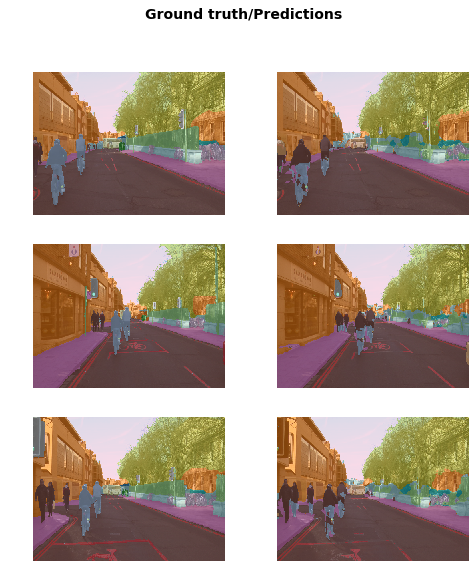

In [41]:
learn.show_results(rows=3, figsize=(8,9))

In [30]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


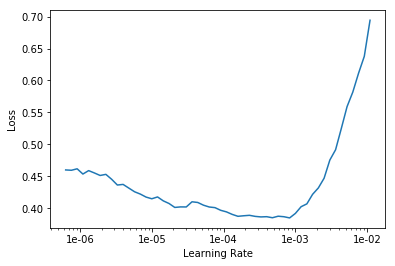

In [31]:
learn.lr_find()
learn.recorder.plot()

In [41]:
lrs = slice(lr/400,lr/4)

In [42]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.375299,0.315975,0.908149,01:50
1,0.365191,0.323436,0.904310,01:49
2,0.343027,0.312580,0.907540,01:50
3,0.345415,0.308021,0.908419,01:50
4,0.332576,0.303652,0.914428,01:50
5,0.332715,0.300468,0.912569,01:50
6,0.333014,0.302229,0.914952,01:50
7,0.320970,0.298648,0.915065,01:50
8,0.327690,0.312516,0.910183,01:50
9,0.314591,0.301056,0.909827,01:50


In [44]:
learn.save('stage-2');

In [43]:
learn.load('stage-2');

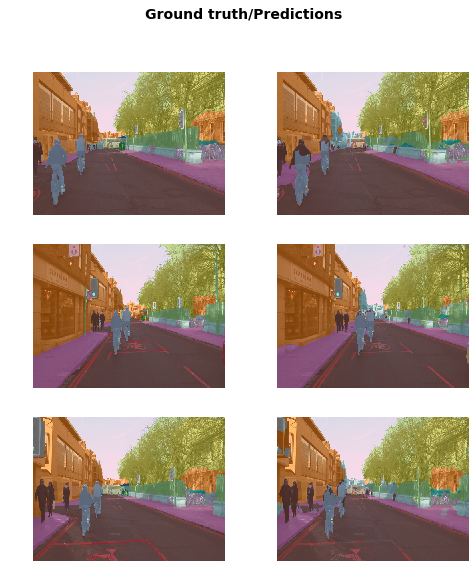

In [46]:
learn.show_results(rows=3, figsize=(8,9))

## Go big

#### Increasing image to original size

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [49]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 7098MB of GPU RAM free


In [50]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [51]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [52]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


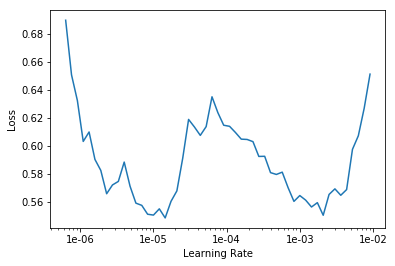

In [53]:
lr_find(learn)
learn.recorder.plot()

In [54]:
lr=1e-3

In [55]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.404170,0.327139,0.909328,07:08
1,0.358621,0.335278,0.910442,07:09
2,0.346227,0.346591,0.905042,07:09
3,0.375103,0.291863,0.920866,07:09
4,0.334867,0.303095,0.915911,07:09
5,0.388814,0.348484,0.901185,07:09
6,0.317811,0.337644,0.912637,07:09
7,0.349948,0.292939,0.919312,07:09
8,0.281794,0.315904,0.919880,07:08
9,0.224918,0.251184,0.929988,07:09


In [56]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

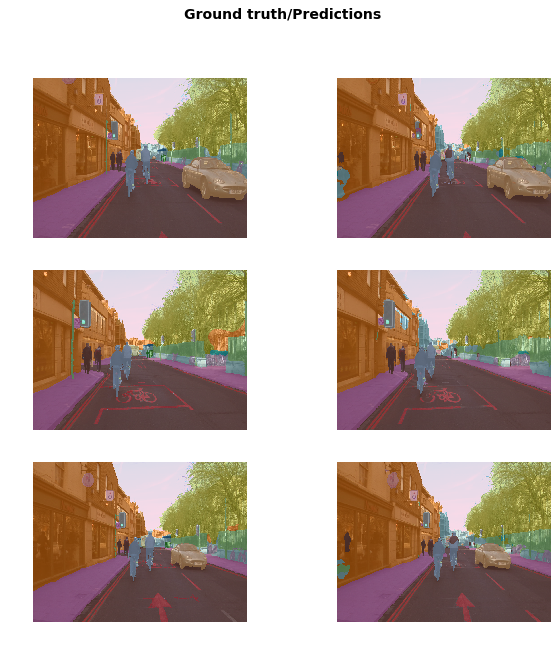

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin